# Assignment 14.1 Building and Evaluating Random Forest and XGBoost Classifier Models

### Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn import metrics
from sklearn.utils import resample

%matplotlib inline

In [2]:
#read dataset
df = pd.read_excel("./data/IIMK_DSAI_W14_Graded Assignment 14.1_Data Set.xlsx")
df.head()

,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.62507
1,2,No,Yes,817.180407,12106.13470
2,3,No,No,1073.549164,31767.13895
3,4,No,No,529.250605,35704.49394
4,5,No,No,785.655883,38463.49588


### Data Visualisation and Augmentation  

In [3]:
df.isnull().sum()

Unnamed: 0    0
default       0
student       0
balance       0
income        0
dtype: int64

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  10000 non-null  int64  
 1   default     10000 non-null  object 
 2   student     10000 non-null  object 
 3   balance     10000 non-null  float64
 4   income      10000 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 390.8+ KB


In [5]:
df.describe()

,Unnamed: 0,balance,income
count,10000.00000,10000.000000,10000.000000
mean,5000.50000,835.374886,33516.981876
std,2886.89568,483.714985,13336.639563
min,1.00000,0.000000,771.967729
25%,2500.75000,481.731105,21340.462905
50%,5000.50000,823.636973,34552.644800
75%,7500.25000,1166.308387,43807.729275
max,10000.00000,2654.322576,73554.233500


In [6]:
# drop Serial number or Unnamed column
df = df.drop('Unnamed: 0', axis='columns')
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.62507
1,No,Yes,817.180407,12106.13470
2,No,No,1073.549164,31767.13895
3,No,No,529.250605,35704.49394
4,No,No,785.655883,38463.49588


In [7]:
# find out imbalances in dataset
df.default.value_counts()

default
No     9667
Yes     333
Name: count, dtype: int64

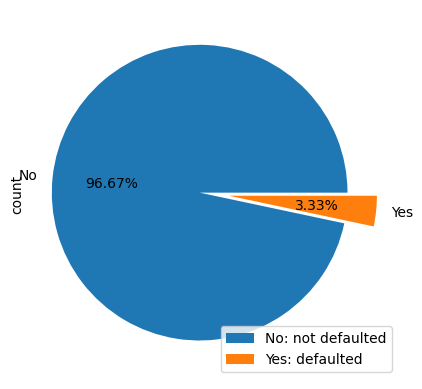

In [8]:
d=df.default.value_counts()
d.plot(kind='pie', subplots=True, autopct='%1.2f%%', explode=(0.1, 0.1))
plt.legend(['No: not defaulted','Yes: defaulted'])

In [9]:
# since the dataset is imbalanced, we need to use oversampling to balance it.
df_defaulted = df[df.default == 'Yes']
df_notdefaulted = df[df.default == 'No']
df_defaulted_new = resample(df_defaulted, replace=True, n_samples=8000)
df_new = pd.concat([df_defaulted_new, df_notdefaulted])
df_new.default.value_counts()

default
No     9667
Yes    8000
Name: count, dtype: int64

In [10]:
# convert categorical columns to numbers
yes_no_cols = ['default', 'student']
for col in yes_no_cols:
    df_new[col].replace({'Yes': 1, 'No': 0}, inplace=True)

In [11]:
df_new.head()

,default,student,balance,income
581,1,1,1770.969441,15975.53720
2126,1,1,1492.963421,11054.06844
9951,1,0,1515.606239,48688.51209
2653,1,1,1707.914634,10591.71742
7552,1,0,1099.057701,42590.89445


In [12]:
#scale balance and income columns
cols_to_scale=['balance', 'income']

for col in cols_to_scale:
    df_new[col] = (df_new[col] - df_new[col].min())/(df_new[col].max() - df_new[col].min())

df_new.head()

,default,student,balance,income
581,1,1,0.667202,0.208891
2126,1,1,0.562465,0.141272
9951,1,0,0.570995,0.658355
2653,1,1,0.643447,0.134920
7552,1,0,0.414063,0.574576


In [13]:
#split into training and test sets
from sklearn.model_selection import train_test_split
X = df_new.drop('default', axis='columns')
y = df_new['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=50, stratify=y)



In [14]:
X_train.shape

(14133, 3)

In [15]:
X_test.shape

(3534, 3)

In [16]:
# Helper methods for model evaluation
def plot_roc_curve(model, title):
    y_prob=model.predict_proba(X_test)[:,1:2]
    fpr, tpr, threshholds = metrics.roc_curve(y_test, y_prob, drop_intermediate=False)
    auc_score = metrics.roc_auc_score(y_test, y_prob)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC Curve (area = %2f)' % auc_score)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]') 
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def plot_confusion_matrix(model, title):
    y_pred = model.predict(X_test)
    cm = metrics.confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8,6))
    sn.heatmap(cm, annot=True, fmt='.2f', xticklabels = ["Subscribed", "Not Subscribed"], yticklabels = ["Subscribed", "Not Subscribed"])
    plt.title(title)
    
def print_classification_report(model, title):
    y_pred = model.predict(X_test)
    print(title)
    print(metrics.classification_report(y_test, y_pred))

### Random Forest Classifier Model Building

In [17]:
#Create the instance of Random Forest Classifier and fit the model
from sklearn.ensemble import RandomForestClassifier

rand_clf = RandomForestClassifier(n_estimators=50, max_depth=10)
rand_clf.fit(X_train, y_train)
rand_clf.score(X_test, y_test)

0.9626485568760611

### XGBoost Classifier Model Construction

In [18]:
#Create the instance of XGBoost Classifier and fit the model
import xgboost
from xgboost import XGBClassifier

xgboost_clf = XGBClassifier(n_estimators=50, max_depth=10)
xgboost_clf.fit(X_train, y_train)
xgboost_clf.score(X_test, y_test)

0.9796264855687606

### Model Evaluation

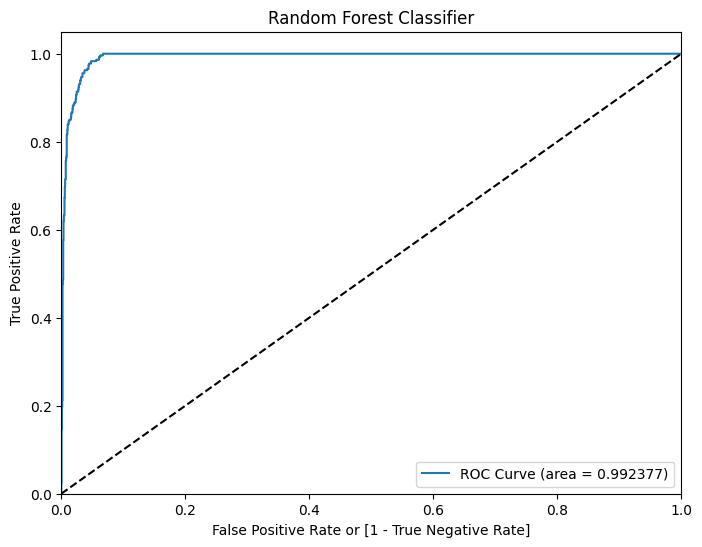

In [19]:
plot_roc_curve(rand_clf, 'Random Forest Classifier')

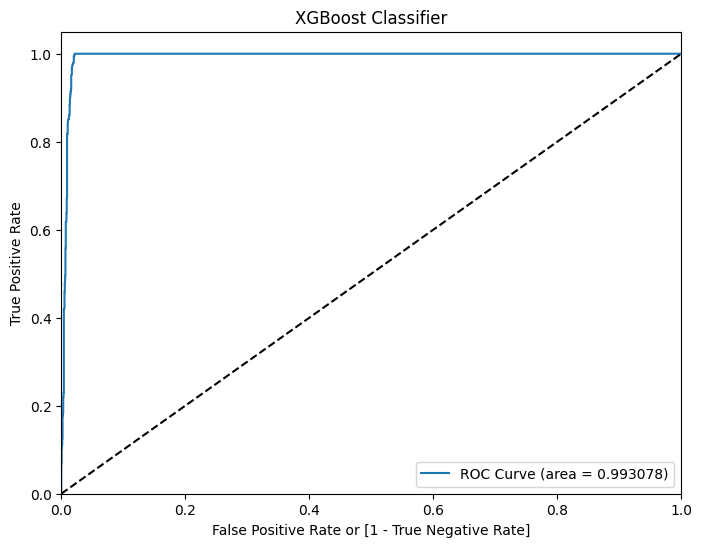

In [20]:
plot_roc_curve(xgboost_clf, 'XGBoost Classifier')

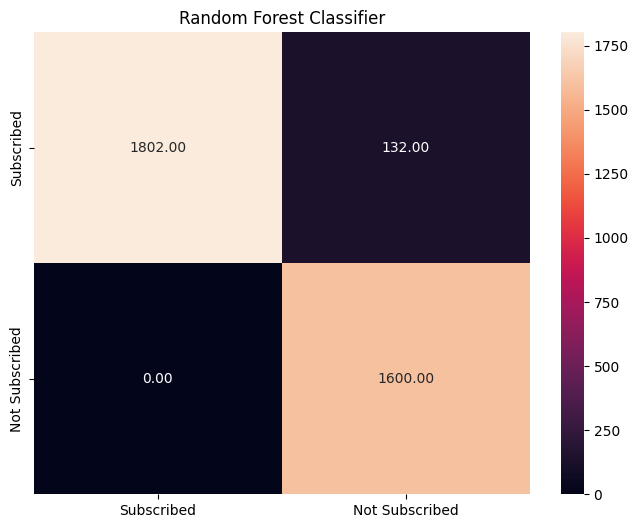

In [21]:
plot_confusion_matrix(rand_clf, "Random Forest Classifier")

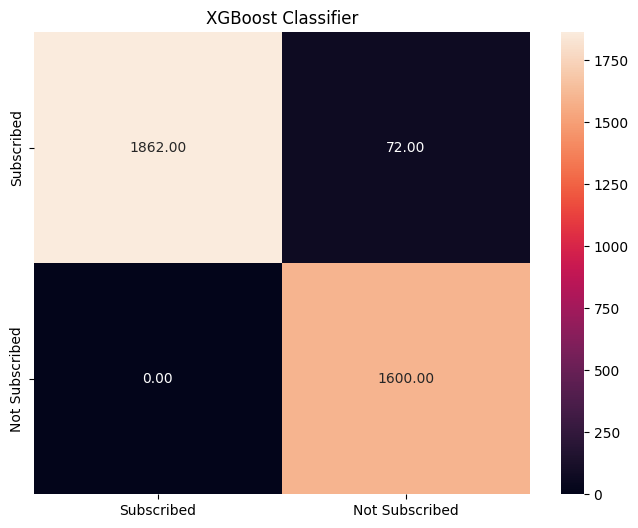

In [22]:
plot_confusion_matrix(xgboost_clf, "XGBoost Classifier")

In [23]:
print_classification_report(rand_clf, 'Random Forest Classifier')

Random Forest Classifier
              precision    recall  f1-score   support

           0       1.00      0.93      0.96      1934
           1       0.92      1.00      0.96      1600

    accuracy                           0.96      3534
   macro avg       0.96      0.97      0.96      3534
weighted avg       0.97      0.96      0.96      3534



In [24]:
print_classification_report(xgboost_clf, 'XGBoost Classifier')

XGBoost Classifier
              precision    recall  f1-score   support

           0       1.00      0.96      0.98      1934
           1       0.96      1.00      0.98      1600

    accuracy                           0.98      3534
   macro avg       0.98      0.98      0.98      3534
weighted avg       0.98      0.98      0.98      3534



### Performance

XGBoost Classifier is performance is slightly better than Random Forest Classifier with better precision, recall and accuracy.